In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

In [2]:
c0 = -1
c1 = 0.4
c2 = 0.2
c3 = 3
c4 = 0.5
c5 = 0.5

a1 = 0.1
a2 = 0.05
a3 = 1
alpha = 1

def general_loss_function(theta):
    return c0 * np.cos(c1*theta) + c2 * np.sin(c3 * (theta - c4)) + c5

def strongly_convex_loss_function(theta):
    return c2*theta**2 - c1 * theta - alpha

theta_optimal = c1/(2*c2)

In [3]:
# c0 = -1
# c1 = 0.1
# c2 = 0.05
# c3 = 3
# c4 = 0.5
# alpha = 1
# beta = -0.5

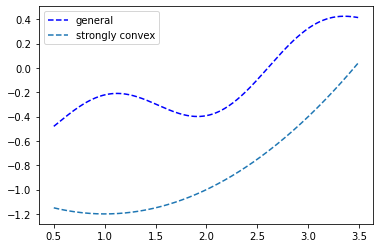

In [4]:
# evenly sampled time at 200ms intervals
mus = np.arange(0.5, 3.5, 0.01)

# red dashes, blue squares and green triangles
plt.plot(mus, general_loss_function(mus), 'b--', label='general')
plt.plot(mus, strongly_convex_loss_function(mus), '--', label='strongly convex')
plt.legend()
plt.show()

In [5]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, logging_samples, logging_losses, logging_propensities):
    n = logging_losses.shape[0]
    lambd = np.sqrt(18*(np.log(n)))
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + lambd / np.sqrt(n) * std 

def optimist_loss(param, logging_samples, logging_losses, logging_propensities, lambd=0.1):
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean - lambd * std

In [6]:
loss_mode = 'convex'
loss_function = general_loss_function if loss_mode == 'general' else strongly_convex_loss_function 

In [7]:
def optimize(loss_fun, init_parameter, args):

    lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B")

    lbfgs_sol = lbfgsb.run(init_parameter, *args).params
    
    lbfgs_fun_val = lbfgsb.run(init_parameter, *args).state.fun_val
    
    return lbfgs_sol, lbfgs_fun_val

In [8]:
def plot_dynamic(estimates, optimized_mus, name, title):
    
    ### Estimates
    estimate_means = estimates['means']
    estimate_stds = estimates['stds']
    ess_diagnostics = estimates['ess']
    number_episodes = len(optimized_mus)
    
    y_lim_up = 0.2
    y_lim_down = -1.5
    ### Create figure
    plt.figure(figsize=(16, 12))

    ### Loss function and its estimate, its confidence bound
    plt.plot(mus, loss_function(mus), 'b', label='loss function')
    plt.plot(mus, estimate_means, '-.', label='estimated loss')
    plt.fill_between(mus, (estimate_means-estimate_stds), (estimate_means+estimate_stds), where=(ess_diagnostics>=0.01), color='b', alpha=.1, label='confidence set')

    ### Confidence/constrained region
    plt.fill_between(mus, y_lim_down, y_lim_up, where=(ess_diagnostics<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')

    ### Logging mu and associates
    plt.axvline(x=optimized_mus[0], color='limegreen', linestyle='--', label=r'$\theta_{}$'.format(0))
    for index in range(1, number_episodes-1):
        mu = optimized_mus[index]
        plt.axvline(x=mu, color='limegreen', linestyle='--')
    index, mu = len(optimized_mus)-1, optimized_mus[-1] # last value is in black
    plt.axvline(x=mu, color='k', linestyle='--', label=r'$\theta_M$'.format(index))

    plt.axvline(x=theta_optimal, color='blue', linestyle='--', label=r'$\theta^*$')
    ### Legends, labels, ticks, save figure
    plt.legend(loc='upper left')
    plt.xlabel(r'$\theta$')
    ticks_x, ticks_label = [1, 2], ['1', '2']
    ticks_x += [theta_optimal, optimized_mus[0], optimized_mus[-1]]
    ticks_label += [r'$\theta^*$', r'$\theta_0$', r'$\theta_M$']
    plt.xticks(ticks_x, ticks_label)
    plt.ylim(y_lim_down, y_lim_up)
    plt.title('{}'.format(title))
    plt.savefig('gaussian_{}.pdf'.format(name))
    plt.show()

### Data

# Experiment

In [9]:
logging_mu = 3
logging_scale = 0.2

def get_logging_data(n_samples, random_seed=123):

    rng = np.random.RandomState(random_seed)
    action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
    losses = loss_function(action_samples)
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    propensities = logging_pdf(action_samples)
    loss = np.mean(losses)

    logging_data = action_samples, losses, propensities

    return logging_data

### Repeated CRM

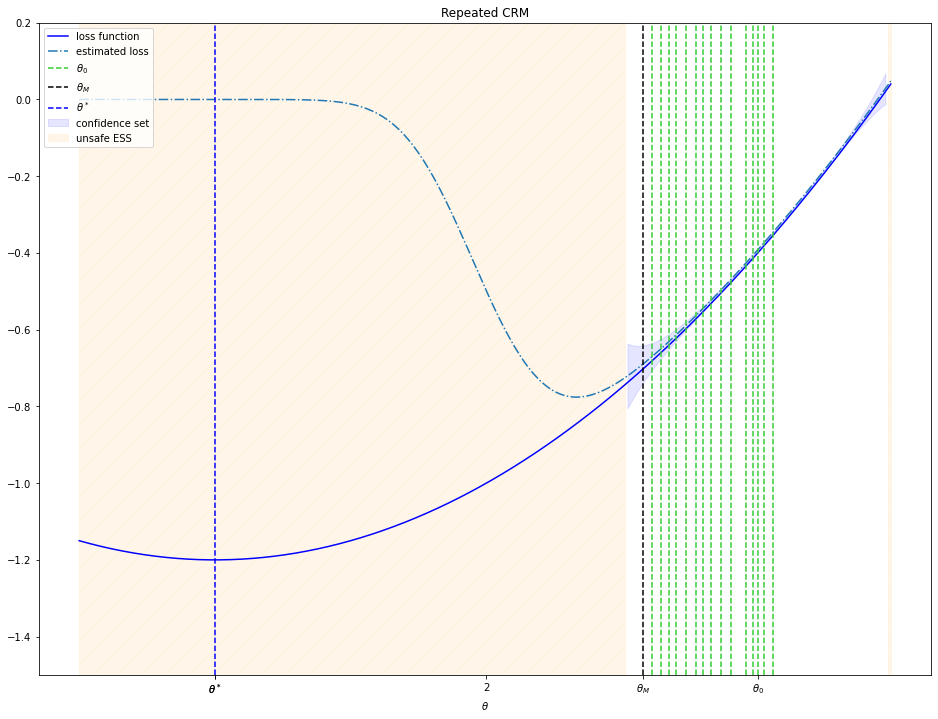

In [11]:

def repeated_crm_experiment(random_seed=42):

    loss_fun = conservative_loss 

    rng = np.random.RandomState(random_seed)
    repeated_crm_online_losses = []

    M = 15
    n_samples = 100
    n_total = n_samples
    mu = logging_mu
    logging_pdf = norm(loc=logging_mu\
                       , scale=logging_scale).pdf
    optimized_mus = [mu]
    compteur = 0
    logging_data = get_logging_data(n_samples, random_seed)
    logging_samples, logging_losses, logging_propensities = logging_data

    for m in range(M):
        
        def get_estimates(mu, logging_data):

            def estimates(mu, logging_data):
                logging_samples, logging_losses, logging_propensities = logging_data
                running_pdf = norm(loc=mu, scale=logging_scale).pdf
                importance_weights = running_pdf(logging_samples)/logging_propensities
                ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
                return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

            estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
            estimate_means, ess_diagnostics, estimate_stds = np.array(estimate_means), np.array(ess_diagnostics), np.array(estimate_stds)
            lambd = np.sqrt(18*(np.log(n_total)))

            stds = lambd*estimate_stds/np.sqrt(n_total) + lambd**2/(n_total-1) 
            estimates = {
                'means': estimate_means,
                'stds': stds,
                'ess': ess_diagnostics,
            }

            return estimates

        init_parameter = jnp.array(logging_mu, dtype='float32')
        args = logging_data

        optimized_mu, loss_crm = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)

            
        mu = optimized_mu._value
    
        n_samples *= 2 
        action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
        losses = loss_function(action_samples)
        propensities = logging_pdf(action_samples)
        online_loss = np.mean(loss_function(rng.normal(loc=mu, scale=logging_scale, size=n_samples)))
        repeated_crm_online_losses.append(online_loss)

        logging_samples = np.hstack([logging_samples, action_samples])
        logging_losses = np.hstack([logging_losses, losses])
        logging_propensities = np.hstack([logging_propensities, propensities])
        logging_data = logging_samples, logging_losses, logging_propensities
        n_total += n_samples
    

    estimates = get_estimates(logging_mu, logging_data)
    plot_dynamic(estimates, optimized_mus, name='repeated_crm', title='Repeated CRM')
    
    return repeated_crm_online_losses


repeated_crm_online_losses = repeated_crm_experiment()


### Sequential CRM

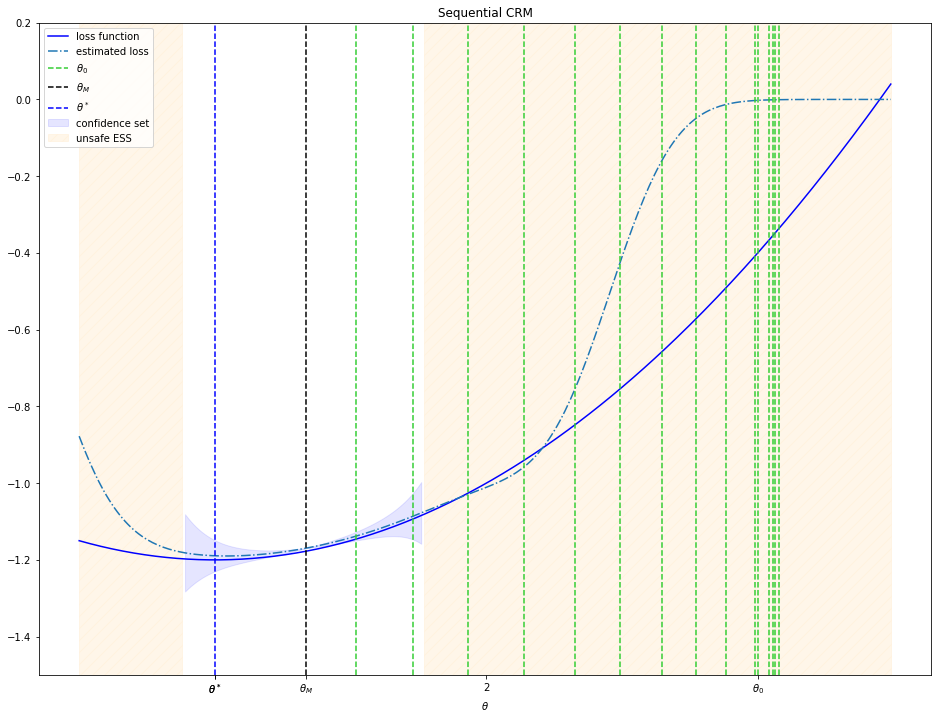

In [12]:
    
def sequential_crm_experiment(random_seed=42):

    loss_fun = conservative_loss 
    

    M = 15
    n_samples = 100
    
    mu = logging_mu
    optimized_mus = [mu]
    logging_data = get_logging_data(n_samples, random_seed)
    
    rng = np.random.RandomState(random_seed)
    sequential_crm_online_losses = []

    for m in range(M):

        def get_estimates(mu, logging_data):

            def estimates(mu, logging_data):
                logging_samples, logging_losses, logging_propensities = logging_data
                running_pdf = norm(loc=mu, scale=logging_scale).pdf
                importance_weights = running_pdf(logging_samples)/logging_propensities
                ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
                return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

            estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
            estimate_means, ess_diagnostics, estimate_stds = np.array(estimate_means), np.array(ess_diagnostics), np.array(estimate_stds)
            
            lambd = np.sqrt(18*(np.log(n_samples)))

            stds = lambd*estimate_stds/np.sqrt(n_samples) + lambd**2/(n_samples-1) 
            
            estimates = {
                'means': estimate_means,
                'stds': stds,
                'ess': ess_diagnostics,
            }

            return estimates

        
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu, loss_crm = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)
        


        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value

        logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
        logging_losses = loss_function(logging_samples)
        online_loss = np.mean(logging_losses)
        sequential_crm_online_losses.append(online_loss)
        logging_pdf = norm(loc=mu, scale=logging_scale).pdf
        logging_propensities = logging_pdf(logging_samples)


        logging_data = logging_samples, logging_losses, logging_propensities
        
        
    estimates = get_estimates(mu, logging_data)
    plot_dynamic(estimates, optimized_mus, 'sequential_crm', 'Sequential CRM')
    
    return sequential_crm_online_losses

sequential_crm_online_losses = sequential_crm_experiment()


### Plot results

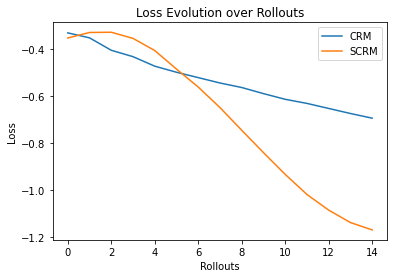

In [13]:
# fig, ax = plt.subplots(constrained_layout=True)
plt.title('Loss Evolution over Rollouts')
plt.xlabel('Rollouts')
plt.ylabel('Loss')
plt.plot(repeated_crm_online_losses, label='CRM')
plt.plot(sequential_crm_online_losses, label='SCRM')
plt.legend(loc='upper right')
plt.savefig('gaussian_losses.pdf')